### This notebook tries to forecast the No of jobs for pre-covid Australia and post-covid Australia using the   Labour Force Statistical dataset provided by the Australian Bureau of Statistics

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 23
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['text.color'] = 'k'

In [2]:
emp_data = pd.read_excel("EmployUnemploy19-20.xlsx", sheet_name="EmpTotal", parse_dates=[0])

In [3]:
emp_data.head(5)

,Time,Fulltime
0,1978-02-01,5985.659716
1,1978-03-01,6040.560795
2,1978-04-01,6054.213859
3,1978-05-01,6038.264751
4,1978-06-01,6031.342299


In [4]:
emp_data.set_index('Time', inplace=True)

##### Visualizing Time series data

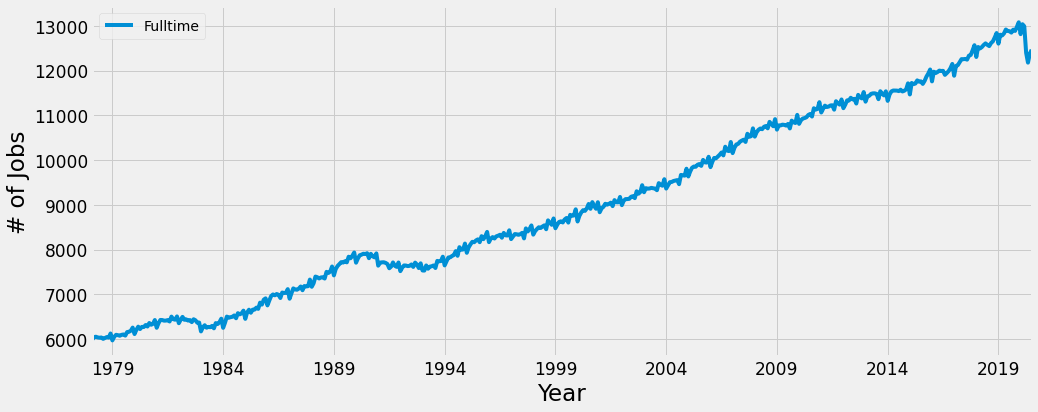

In [5]:
ax = emp_data.plot(figsize=(15, 6))

ax.set_xlabel('Year')
ax.set_ylabel('# of Jobs')

plt.legend()
plt.show()

##### Visualizing decomposed data in Seasonality, Trend and noise

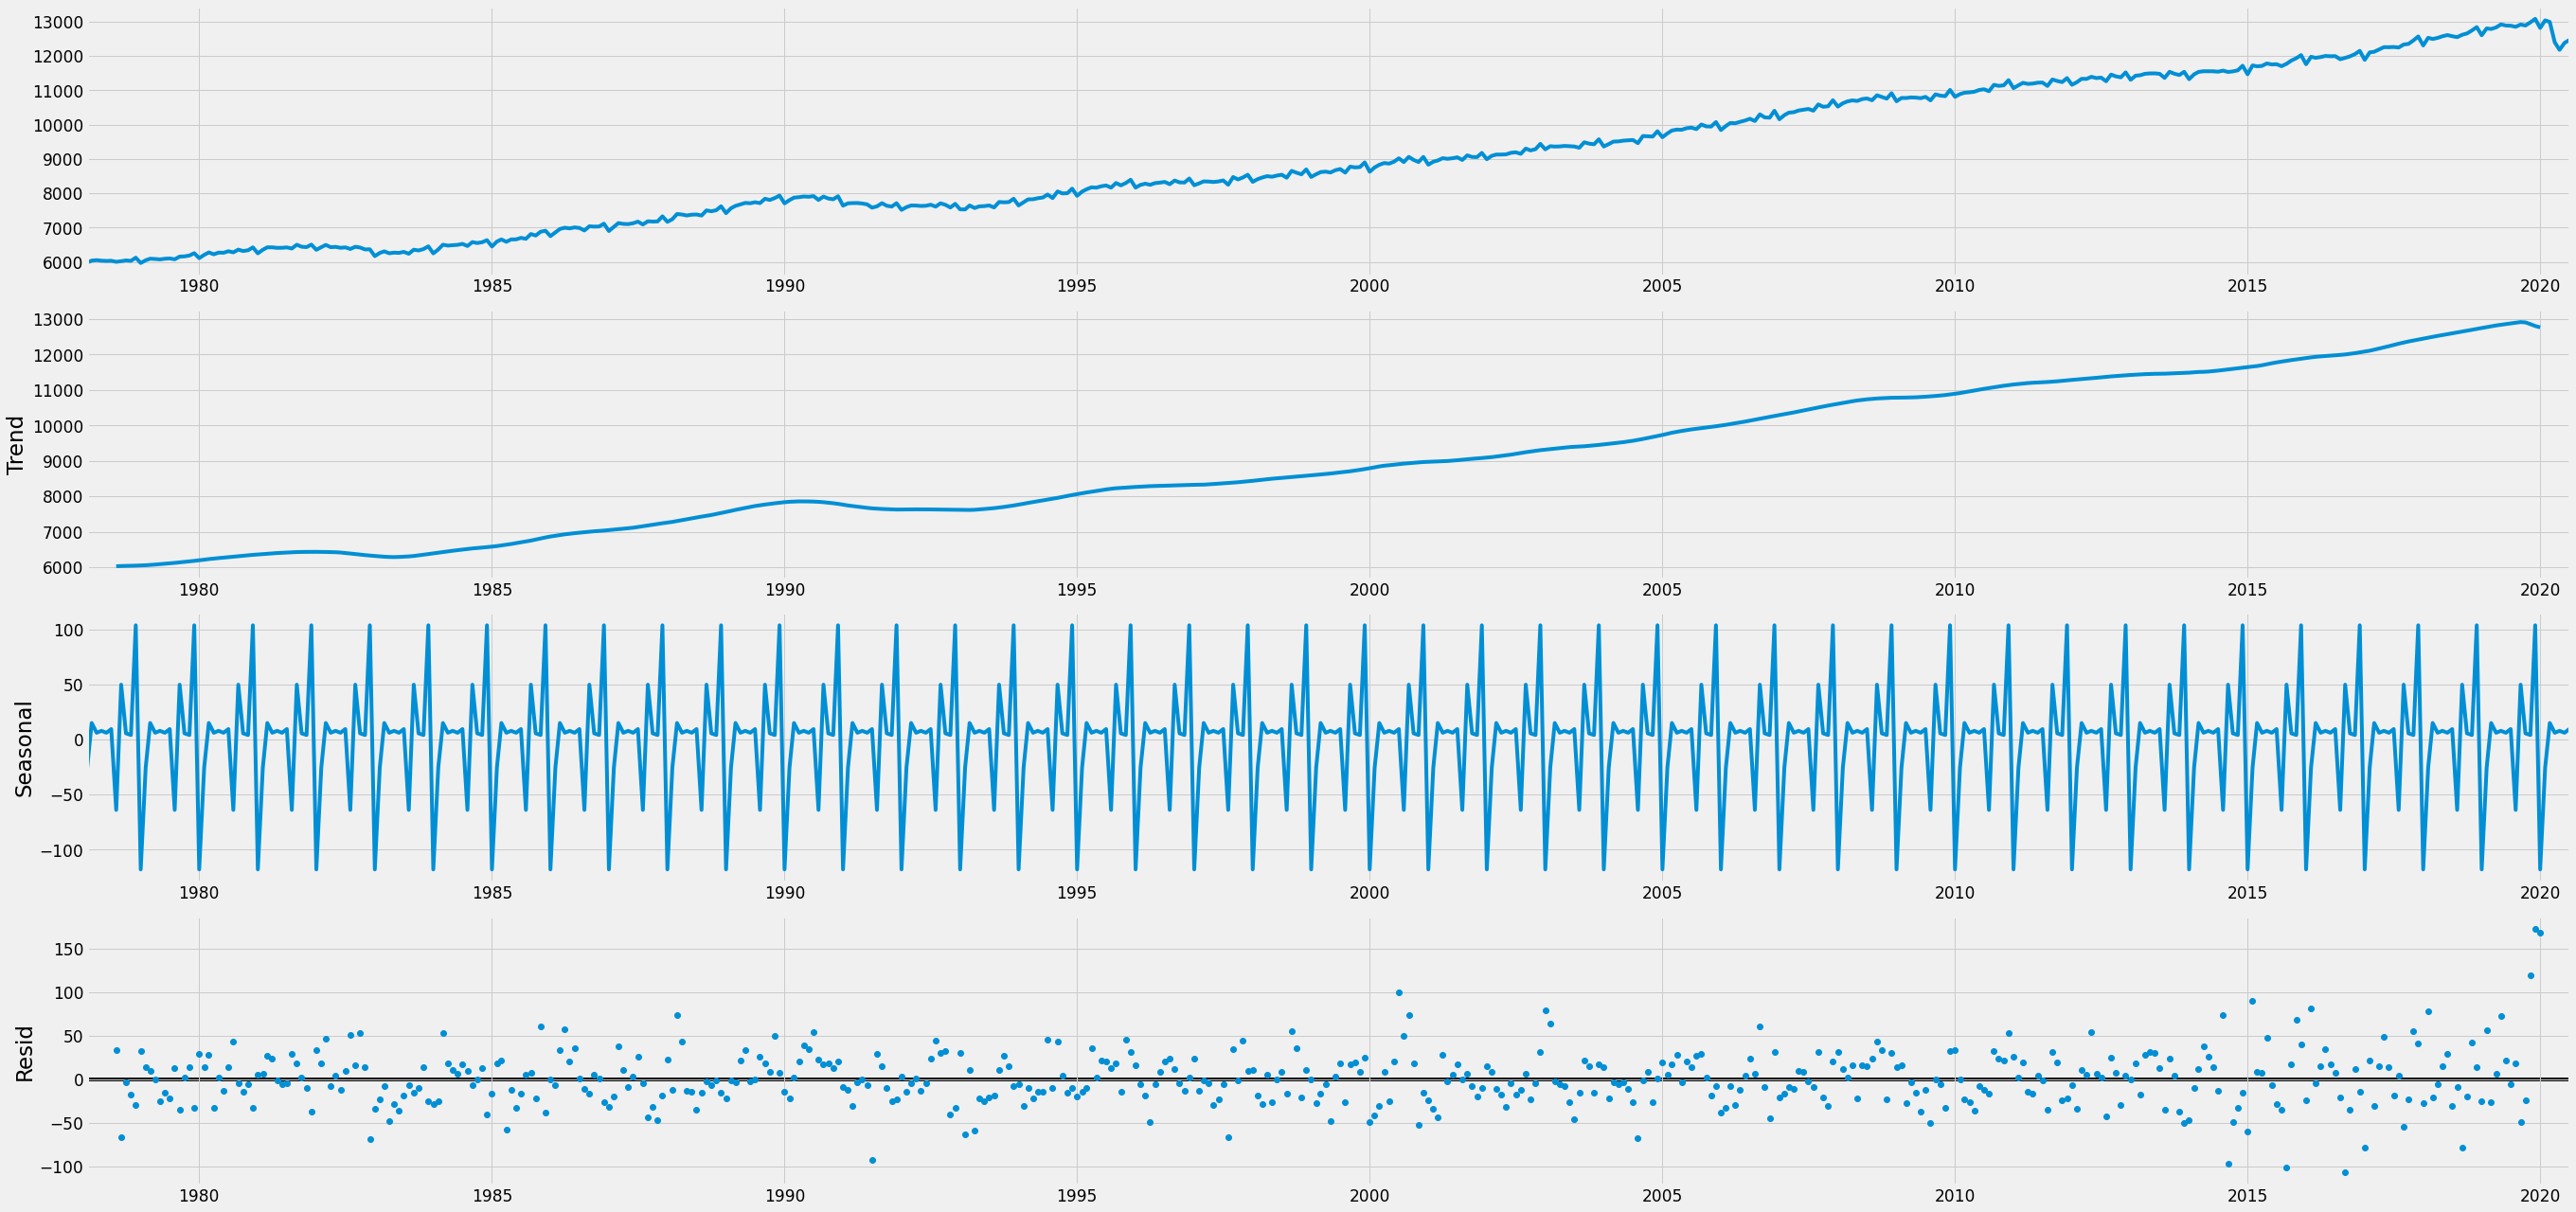

In [6]:
rcParams['figure.figsize'] = 38, 18
decomposition = sm.tsa.seasonal_decompose(emp_data, model='additive')
fig = decomposition.plot()
plt.show()

##### Firstly, trying to predict the jobs if there would have been no pandemic

In [7]:
# discarding the last seven rows containing the Job count of 7 months of 2020
emp_data_till_2019 = emp_data.iloc[:-7]

##### ARIMA Model

In [8]:
# parameter p,d and q stands for seasonality, trend and noice
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [9]:
# parameter selection for our model to find the optimal parameters for ARIMA Model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(emp_data_till_2019,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10590.820438456369
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10007.169272920579
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6633.831182060692
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6271.087838022464
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6112.448882938372
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6076.341121094512
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6113.245494692566
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6011.021983119339
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10202.509110858198
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:9872.489330595323
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6092.1448996066465
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5829.281784720566
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5690.923992974014
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5666.734354177792
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5749.5178988772
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5589.2632764172495
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5993.692131067637
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5522.836616936847
ARIMA(0

In [10]:
# Using the parameters that gives least AIC value
mod = sm.tsa.statespace.SARIMAX(emp_data_till_2019,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1988      0.035     -5.740      0.000      -0.267      -0.131
ma.S.L12      -0.6678      0.035    -18.951      0.000      -0.737      -0.599
sigma2      1241.4181     56.986     21.785      0.000    1129.728    1353.108


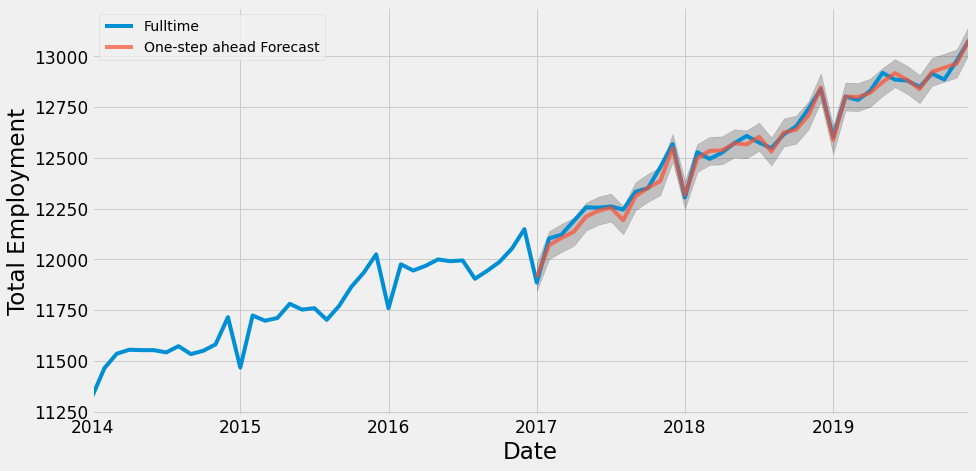

In [11]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = emp_data_till_2019['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Employment')

plt.legend()
plt.show()

##### The below graph shows the Job forecast if the Covid pandemic had not occurred

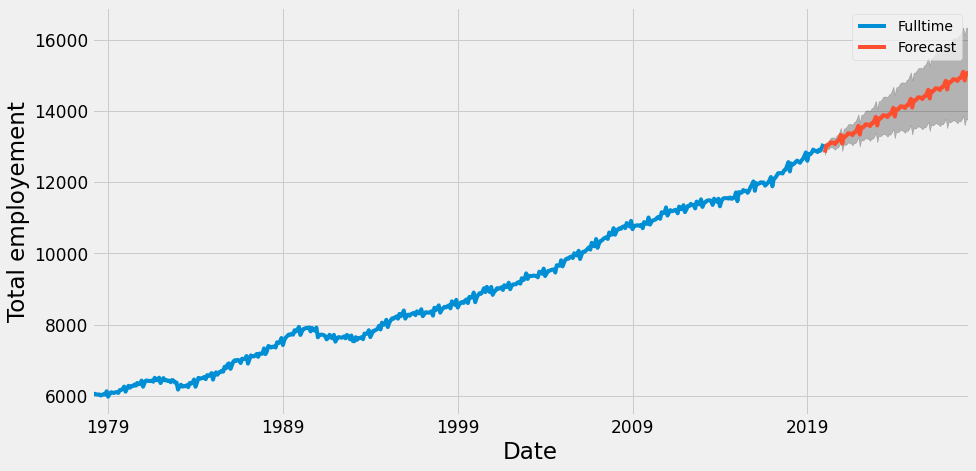

In [12]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = emp_data_till_2019.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Total employement')
plt.legend()
plt.show()

##### Now we will try to forecast the job count given the pandemic

##### ARIMA Model

In [13]:
# parameter p,d and q stands for seasonality, trend and noice
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
# parameter selection for our model to find the optimal parameters for ARIMA Model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(emp_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10744.57389284627
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:9872.482348738378
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6750.633561189878
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6412.714162942285
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6333.462281469678
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6307.809451980342
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6300.253998364575
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6224.271087627482
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10350.943820962748
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10019.501501556822
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6205.544617178181
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5959.4387818385
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5894.4732272374495
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5873.021317036339
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5911.060144482899
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5785.447016094449
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6129.81046414688
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5709.208081446513
ARIMA(0, 1

##### This model gives the lowest AIC: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:5134.295692976764

In [15]:
mod = sm.tsa.statespace.SARIMAX(emp_data,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0112      0.014      0.810      0.418      -0.016       0.038
ma.S.L12      -0.6919      0.059    -11.816      0.000      -0.807      -0.577
sigma2      2377.0069     33.863     70.195      0.000    2310.637    2443.377


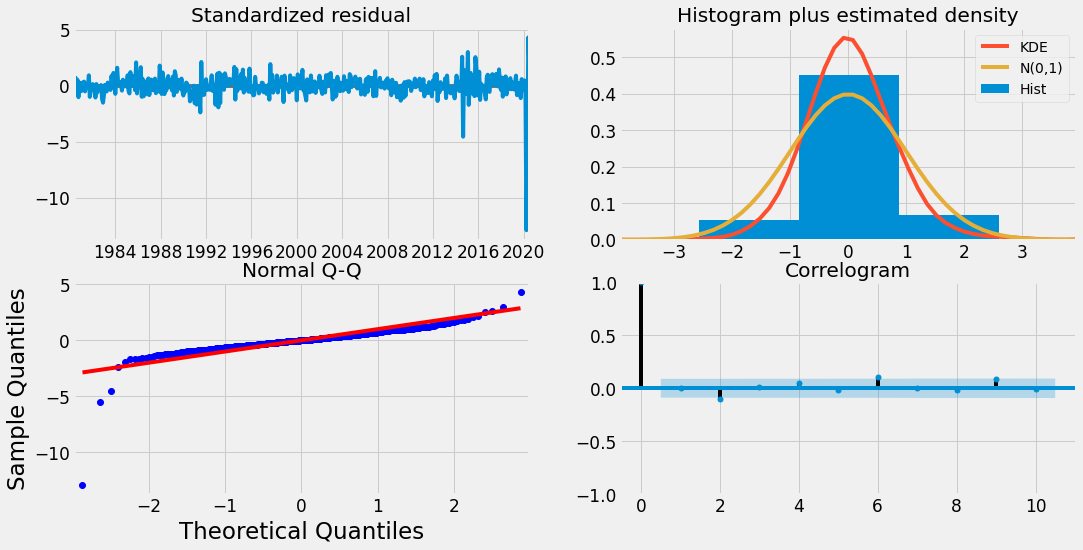

In [16]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

##### Validating Forecasts

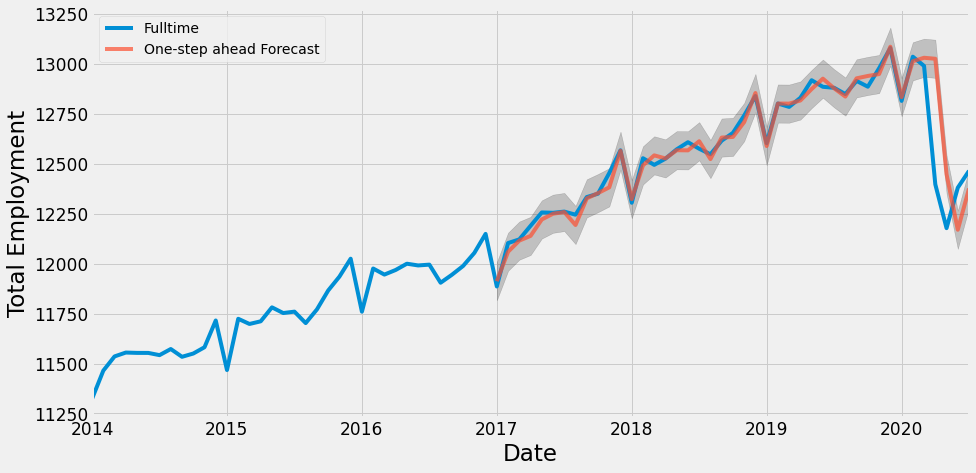

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = emp_data['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Employment')

plt.legend()
plt.show()

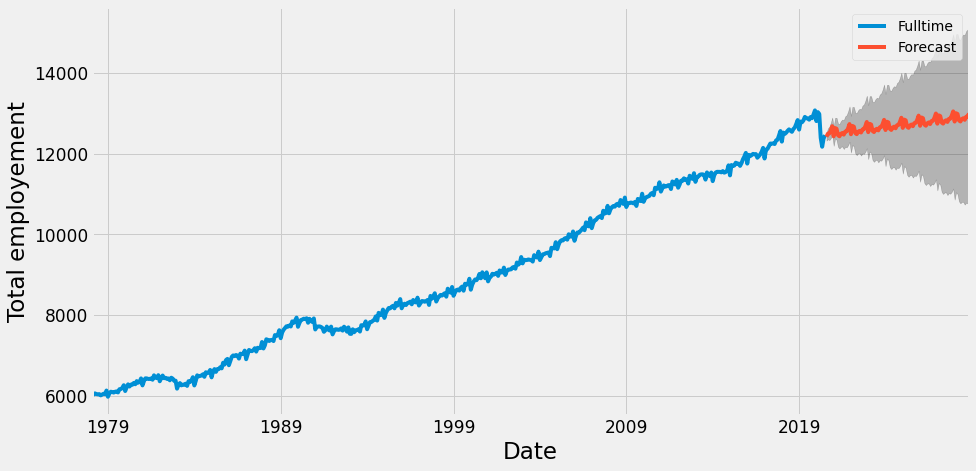

In [18]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = emp_data.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Total employement')
plt.legend()
plt.show()

##### CONCLUSION

##### By comparing the above two graphs it is clear that the Job count that was forecasted before pandemic was higher as compared to the job count that is forecasted after pandemic